In [1]:
'''
Author: Sameer
Date: 16/11/2018
RBF Classification = K-Means + Perceptron Learning Alogrithm
'''

'\nAuthor: Sameer\nDate: 16/11/2018\nRBF Classification = K-Means + Perceptron Learning Alogrithm\n'

In [2]:
# Import Required Libraries
import numpy
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
# Parameters
Input_Samples = 100
# C = 1
Centers = 20
grid_size = 500
eta = 0.3 # Learning Rate
Epoch = numpy.array([]) # Storing Epoch for plotting
Misclassification = numpy.array([]) # No.of Wrong Classifications

In [4]:
# Check if data exists. If yes load it otherwise create new data and store it in text file.
# Data includes the points for the classification problem, Centers for K-Means Algo and Weights & Bias.
# Half of the centers will be for Positive Class and other half will be for  Negative class.
# Weight includes bias.
if numpy.DataSource().exists('InputPattern.txt'):
    X = numpy.loadtxt('InputPattern.txt')
else:
    X = numpy.random.uniform(0, 1, (Input_Samples, 2))
    numpy.savetxt('InputPattern.txt', X)
if numpy.DataSource().exists('Weights.txt'):
    Weights = numpy.loadtxt('Weights.txt')
else:
#     Weights = numpy.random.uniform(-1, 1, (1 + int(Centers)))
    Weights = numpy.random.normal(0, 0.3086067, (1 + int(Centers)))
    numpy.savetxt('Weights.txt', Weights)
Gaussian_Std_Deviation = numpy.std(X)

In [5]:
# Create Desired Classification based on some conditions.
# Which will give a circle and sine wave boundary and points lying inside them will be positive class, negative otherwise.
D = numpy.array([])
Pos_Class = numpy.array([[0, 0]])
Neg_Class = numpy.array([[0, 0]])
for i in range(0, Input_Samples):
    if X[i, 1] < 0.2 * numpy.sin(10 * X[i, 0]) + 0.3 or numpy.square(X[i, 0] - 0.5) + numpy.square(X[i, 1] - 0.8) < numpy.square(0.15):
        D = numpy.concatenate((D, [1]), axis=0)
        Pos_Class = numpy.concatenate((Pos_Class, [X[i]]), axis=0)
    else:
        D = numpy.concatenate((D, [-1]), axis=0)
        Neg_Class = numpy.concatenate((Neg_Class, [X[i]]), axis=0)
Pos_Centers = Pos_Class[numpy.random.choice(Pos_Class.shape[0], int(Centers/2), replace=False), :]
Neg_Centers = Neg_Class[numpy.random.choice(Neg_Class.shape[0], int(Centers/2), replace=False), :]

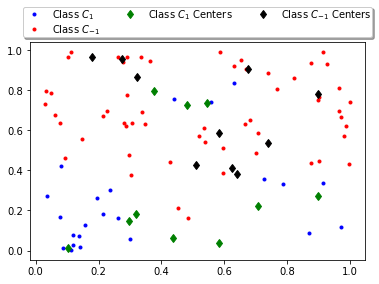

In [6]:
# Plot Results
plt.plot(Pos_Class[1:, 0], Pos_Class[1:, 1], 'b.', label=r'Class $C_1$')
plt.plot(Neg_Class[1:, 0], Neg_Class[1:, 1], 'r.', label=r'Class $C_{-1}$')
plt.plot(Pos_Centers[:, 0], Pos_Centers[:, 1], 'gd', label=r'Class $C_1$ Centers')
plt.plot(Neg_Centers[:, 0], Neg_Centers[:, 1], 'kd', label=r'Class $C_{-1}$ Centers')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), fancybox=True, shadow=True, ncol=3, borderpad=0.1, labelspacing=0.1)
plt.savefig('Results1.pdf')
plt.show()

In [7]:
# Required Functions
def Gaussian_Kernel(X1, X2, sigma):
    return numpy.exp(-numpy.square(numpy.linalg.norm(X1 - X2))/(2 * numpy.square(sigma)))

# def MulitQuadratic_Kernel(X1, X2, c):
#     return numpy.sqrt(numpy.square(numpy.linalg.norm(X1 - X2)) + numpy.square(c))

# def Inverse_MulitQuadratic_Kernel(X1, X2, c):
#     return 1/(numpy.sqrt(numpy.square(numpy.linalg.norm(X1 - X2)) + numpy.square(c)))

def KMeans(points, centers, std_dev):
    labels = numpy.zeros(len(points))
    centers_old = numpy.zeros((len(centers), 2)) 
    centers_new = deepcopy(centers)
    Error = numpy.linalg.norm((centers_new - centers_old), axis=1)
    variance = numpy.array([])
    while Error.all() != 0:
        for i in range(0, len(points)):
            min_dist_label = numpy.argmin(numpy.linalg.norm((points[i] - centers), axis=1))
            labels[i] = min_dist_label
        centers_old = deepcopy(centers_new)
        for i in range(0, len(centers)):
            temp = numpy.array([points[j] for j in range(0, len(points)) if labels[j] == i])
            if temp.size != 0:
                centers_new[i] = numpy.mean(temp, axis=0)
                variance = numpy.concatenate((variance, [numpy.std(temp)]), axis=0)
            else:
                centers_new[i] = centers_old[i]
                variance = numpy.concatenate((variance, [std_dev]), axis=0)
        Error = numpy.linalg.norm((centers_new - centers_old), axis=1)
    return centers_new, variance

def eval_perceptron(points, labels, centers, variance, weights):
    m = 0
    for i in range(0, len(points)):
        input_vector = numpy.array([Gaussian_Kernel(points[i], centers[j], variance[j]) 
                                    for j in range(0, len(centers))])
        input_vector = numpy.concatenate(([1], input_vector))
        induced_local_field = numpy.dot(weights, input_vector)
        if induced_local_field * labels[i] < 0:
            m += 1
    return m

def update_weights(points, labels, centers, variance, weights, lr):
    for i in range(0, len(points)):
        input_vector = numpy.array([Gaussian_Kernel(points[i], centers[j], variance[j]) 
                                    for j in range(0, len(centers))])
        input_vector = numpy.concatenate(([1], input_vector))
        induced_local_field = numpy.dot(weights, input_vector)
        if induced_local_field >= 0:
            output = 1
        else:
            output = -1
        weights = weights + lr * (labels[i] - output) * input_vector
    return weights

def PTA(points, labels, final_centers, final_variance, weights, lr, epoch, misclassification):
    e = 0
    m = eval_perceptron(points, labels, final_centers, final_variance, weights)
    weights_current = update_weights(points, labels, final_centers, final_variance, weights, lr)
    # Book Keeping
    misclassification = numpy.concatenate((misclassification, [m]), axis=0)
    epoch = numpy.concatenate((epoch, [e]), axis=0)
    # Print
    print('Number of errors in the Epoch ', e, ': \t', m)
    while m > 0:
        e += 1
        m = eval_perceptron(points, labels, final_centers, final_variance, weights_current)
        weights_current = update_weights(points, labels, final_centers, final_variance, weights_current, lr)
        # Book Keeping
        misclassification = numpy.concatenate((misclassification, [m]), axis=0)
        epoch = numpy.concatenate((epoch, [e]), axis=0)
        # Print
        print('Number of errors in the Epoch ', e, ': \t', m)
    print('Optimal Weight Reached!!!')
    return weights_current, epoch, misclassification

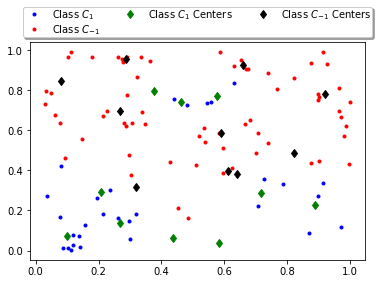

In [8]:
# K-Means Algo: Final Centers
Final_Pos_Centers, VP = KMeans(Pos_Class, Pos_Centers, Gaussian_Std_Deviation)
Final_Neg_Centers, VN = KMeans(Neg_Class, Neg_Centers, Gaussian_Std_Deviation)
Final_Centers = numpy.concatenate((Final_Pos_Centers, Final_Neg_Centers), axis=0)
Final_Variance = numpy.concatenate((VP, VN), axis=0)
# Plot Results
plt.plot(Pos_Class[1:, 0], Pos_Class[1:, 1], 'b.', label=r'Class $C_1$')
plt.plot(Neg_Class[1:, 0], Neg_Class[1:, 1], 'r.', label=r'Class $C_{-1}$')
plt.plot(Final_Pos_Centers[:, 0], Final_Pos_Centers[:, 1], 'gd', label=r'Class $C_1$ Centers')
plt.plot(Final_Neg_Centers[:, 0], Final_Neg_Centers[:, 1], 'kd', label=r'Class $C_{-1}$ Centers')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), fancybox=True, shadow=True, ncol=3, borderpad=0.1, labelspacing=0.1)
plt.savefig('Results2.pdf')
plt.show()

In [9]:
# PTA: Final Optimal Weights
Final_Weights, Epoch, Misclassification = PTA(X, D, Final_Centers, Final_Variance, Weights, eta, Epoch, Misclassification)

Number of errors in the Epoch  0 : 	 33
Number of errors in the Epoch  1 : 	 18
Number of errors in the Epoch  2 : 	 8
Number of errors in the Epoch  3 : 	 9
Number of errors in the Epoch  4 : 	 4
Number of errors in the Epoch  5 : 	 15
Number of errors in the Epoch  6 : 	 7
Number of errors in the Epoch  7 : 	 4
Number of errors in the Epoch  8 : 	 9
Number of errors in the Epoch  9 : 	 6
Number of errors in the Epoch  10 : 	 7
Number of errors in the Epoch  11 : 	 7
Number of errors in the Epoch  12 : 	 5
Number of errors in the Epoch  13 : 	 3
Number of errors in the Epoch  14 : 	 6
Number of errors in the Epoch  15 : 	 4
Number of errors in the Epoch  16 : 	 7
Number of errors in the Epoch  17 : 	 7
Number of errors in the Epoch  18 : 	 2
Number of errors in the Epoch  19 : 	 4
Number of errors in the Epoch  20 : 	 4
Number of errors in the Epoch  21 : 	 3
Number of errors in the Epoch  22 : 	 37
Number of errors in the Epoch  23 : 	 4
Number of errors in the Epoch  24 : 	 4
Number

In [13]:
# Generate Boundary
x_points = numpy.linspace(0.0, 1.0, grid_size)
y_points = numpy.linspace(0.0, 1.0, grid_size)
H = numpy.array([[0, 0]]) # Decision Boundary
for i in range(0, grid_size):
    for j in range(0, grid_size):
        temp = numpy.array([x_points[i], y_points[j]])
        input_vector = numpy.array([Gaussian_Kernel(temp, Final_Centers[k], Final_Variance[k])
                                    for k in range(0, len(Final_Centers))])
        input_vector = numpy.concatenate(([1], input_vector))
        induced_local_field = numpy.dot(Final_Weights, input_vector)
        if -0.01 < induced_local_field < 0.01:
            H = numpy.concatenate((H, [temp]), axis=0)

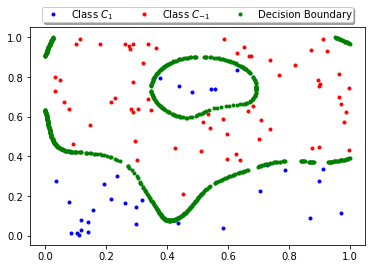

In [14]:
# Plot Results
plt.plot(Pos_Class[1:, 0], Pos_Class[1:, 1], 'b.', label=r'Class $C_1$')
plt.plot(Neg_Class[1:, 0], Neg_Class[1:, 1], 'r.', label=r'Class $C_{-1}$')
plt.plot(H[1:, 0], H[1:, 1], 'g.', label=r'Decision Boundary')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), fancybox=True, shadow=True, ncol=3, borderpad=0.1, labelspacing=0.1)
plt.savefig('Results3.pdf')
plt.show()

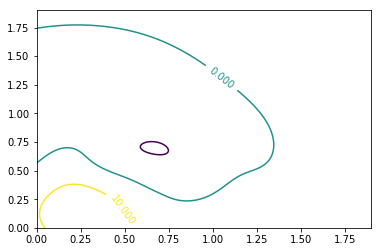

In [29]:
x_points = numpy.linspace(0.0, 1.9, grid_size)
y_points = numpy.linspace(0.0, 1.9, grid_size)
X, Y = numpy.meshgrid(x_points, y_points)
for k in range(0, len(Final_Centers)):
    if k == 0:
        Z = 1 * Final_Weights[k]
    else:
        Z = Z + numpy.exp(-numpy.square((X - Final_Centers[k][0])**2 + (Y - Final_Centers[k][1])**2)/(2 * numpy.square(Final_Variance[k]))) * Final_Weights[k]
fig, ax = plt.subplots()
N = 2
CS = ax.contour(X, Y, Z, N)
ax.clabel(CS, inline=1, fontsize=10)
# plt.plot(Pos_Class[1:, 0], Pos_Class[1:, 1], 'b.', label=r'Class $C_1$')
# plt.plot(Neg_Class[1:, 0], Neg_Class[1:, 1], 'r.', label=r'Class $C_{-1}$')
# plt.plot(Final_Pos_Centers[:, 0], Final_Pos_Centers[:, 1], 'gd', label=r'Class $C_1$ Centers')
# plt.plot(Final_Neg_Centers[:, 0], Final_Neg_Centers[:, 1], 'kd', label=r'Class $C_{-1}$ Centers')
plt.show()